In [19]:
# default_exp geometry.meshed_geometry

# Create meshed geometry

> API details.

In [20]:
#hide
from nbdev.showdoc import *
import matplotlib
import matplotlib.pyplot as plt

In [21]:
#export
import os

In [22]:
#hide
import sys

sys.path.append(os.path.join(os.getcwd(), '..'))

In [23]:
#export
import numpy as np
import gmsh

from accelerate_simulations.geometry import AbstractGeometry

In [24]:
#hide
import meshio

In [25]:
#hide
box_size = (200, 200)
circle_radius_range = (20, 50)
gap = 10
circle_density = 0.90

In [26]:
#hide
abstract_geometry = AbstractGeometry(circle_density, circle_radius_range, box_size, gap, seed=42)

[WARNING] 4584 attempts, reduce circle radius, increase box size, or decrease number of circles
                returning 26 circles
[100.0, 100.0, 200, 200]


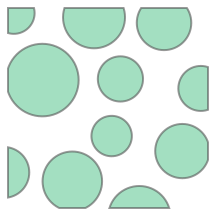

In [27]:
circles, box_coord_dim = abstract_geometry.get_geom_info()
print(box_coord_dim)
circles

In [28]:
#export
def get_circle_info(circle):
    x, y = list(circle.centroid.coords)[0]
    r = circle.length / (np.pi * 2)
    return x, y, r

In [29]:
#export
def add_domain_physical_tags(rectangle_tags, disk_tags, model):
    model.addPhysicalGroup(2, tags=rectangle_tags, tag=2)
    model.setPhysicalName(2, tag=2, name="weak material")

    model.addPhysicalGroup(2, tags=disk_tags, tag=1)
    model.setPhysicalName(2, tag=1, name="strong material")

In [30]:
#export
def identify_rectangle_disk_tags(ov, ovv):
    new_entities = []
    for children in ovv:
        for child in children:
            if child not in ov:
                new_entities.append(child)


    rectangle_tags = [new_entities[0][1]]
    disk_tags = [tag for _, tag in new_entities[1:]]

    return rectangle_tags, disk_tags

In [31]:
#export
def add_disks_rectangle(box_coord_dim, circles, factory, model):
    x_b, y_b, dx_b, dy_b = box_coord_dim
    rectangle = (2, factory.addRectangle(x_b, y_b, 0, dx_b, dy_b))

    disks = []
    for circle in circles:
        x, y, r = get_circle_info(circle)
        disk = factory.addDisk(x, y, 0, r, r)
        disks.append((2, disk))

    ov, ovv = factory.fragment([rectangle], disks)

    # Without synchronization the entities in the OpenCASCADE CAD 
    # representation are not available to any function outside of 
    # the OpenCASCADE CAD kernel functions
    factory.synchronize()

    eps=1e-3
    vin = model.getEntitiesInBoundingBox(
        x_b-eps, y_b-eps, -eps, x_b+dx_b+eps, y_b+dy_b+eps, +eps,
        dim=2
    )

    for v in vin:
        ov.remove(v)
    model.removeEntities(ov, True)

    rectangle_tags, disk_tags = identify_rectangle_disk_tags(ov, ovv)

    return rectangle_tags, disk_tags

In [35]:
#export
def add_boundary_physical_tags(box_coord_dim, model):
    x_b, y_b, dx_b, dy_b = box_coord_dim
    
    eps=1e-3
    limits_right = x_b+dx_b-eps, y_b-eps, -eps, x_b+dx_b+eps, y_b+dy_b+eps, +eps
    limits_left = x_b-eps, y_b-eps, -eps, x_b+eps, y_b+dy_b+eps, +eps
    limits_top = x_b-eps, y_b+dy_b-eps, -eps, x_b+dx_b+eps, y_b+dy_b+eps, +eps
    limits_bot = x_b-eps, y_b-eps, -eps, x_b+dx_b+eps, y_b+eps, +eps

    def add(limits, tag, name):
        vs = model.getEntitiesInBoundingBox(
            *limits,
            dim=1
        )

        model.addPhysicalGroup(1, tags=[v[1] for v in vs], tag=tag)
        model.setPhysicalName(1, tag=tag, name=name)

    add(limits_right, 5, 'right')
    add(limits_left, 3, 'left')
    add(limits_top, 6, 'top')
    add(limits_bot, 4, 'bot')

In [36]:
#export
def make_msh(output_path, abstract_geometry):
    circles, box_coord_dim = abstract_geometry.get_geom_info()

    model = gmsh.model
    factory = model.occ
    
    gmsh.initialize()
    gmsh.option.setNumber("Mesh.MshFileVersion", 2.2) 
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2) 
    gmsh.option.setNumber("Mesh.RecombineAll", 2)

    rectangle_tags, disk_tags = add_disks_rectangle(box_coord_dim, circles, factory, model)

    add_domain_physical_tags(rectangle_tags, disk_tags, model)

    add_boundary_physical_tags(box_coord_dim, model)

    _, _, dx, dy = box_coord_dim
    gmsh.option.setNumber("Mesh.MeshSizeMin", (dx+dy)/50)
    gmsh.option.setNumber("Mesh.MeshSizeMax", (dx+dy)/50)
    model.mesh.generate(dim=2)
    gmsh.model.mesh.refine()
    gmsh.write(output_path)

    gmsh.finalize()

In [37]:
box_size = (200, 200)
circle_radius_range = (20, 50)
gap = 10
circle_density = 0.90

abstract_geometry = AbstractGeometry(
    circle_density, 
    circle_radius_range, 
    box_size, 
    gap, 
    seed=42)

make_msh('test.msh', abstract_geometry)

[WARNING] 4584 attempts, reduce circle radius, increase box size, or decrease number of circles
                returning 26 circles
